# Bathymetric Data Visualization
- __Overall Objective:__ Acquire vector or high-definition raster images of equal-depth lines from Meditteranean bathymetry data.
- __Sub-Objective (for this notebook):__ Get acquainted with how to fetch data from the website.
- __Data:__ You can send requests to [this URL](https://ows.emodnet-bathymetry.eu/wcs?service=wcs&version=1.0.0&request=getcoverage&coverage=) to get raster bathymetry data.  This bathymetric data is recorded and published by the European Marine Observation and Data Network (EMODnet) via their Web Coverage Service (WCS; specifically for posting raster data).

In [1]:
# You can find more detail on these libraries by consulting my install script or
# visiting their page on CRAN.
library(XML)
library(ncdf4)
library(sp)
library(terra)
library(downloader)
library(ggplot2)
library(directlabels)
library(rasterVis)
library(raster)

terra 1.7.55

Loading required package: lattice



In [2]:
source("r_tutorial/helpers.r")

In [3]:
xmin <- 22.0
xmax <- 24.5
ymin <- 39.0
ymax <- 41.0

In [4]:
get_bathymetry <- function(xmin = 22.5, xmax = 25, ymin = 37.5, ymax = 40, resx=1, resy=1) {
  name <- "emodnet:mean"
  bounding_box <- paste(xmin, ymin, xmax, ymax, sep = ",")
  url <- paste("https://ows.emodnet-bathymetry.eu/wcs?service=wcs&version=1.0.0&request=getcoverage&coverage=",
               name, "&crs=EPSG:4326&BBOX=", bounding_box,
               "&format=image/tiff&interpolation=nearest&resx=", resx, "&resy=", resy,
               sep = "")
  print(url)
  temp <- paste(name, "img.tiff", sep = "_")
  temp <- tempfile(temp)
  download.file(url, temp, quiet = FALSE, mode = "wb")
  img_raw <- raster(temp)
  img_raw <- -1*img_raw
  img_raw[img_raw < 0] <- 0
  img_raw[img_raw == 0] <- NaN
  return(img_raw)
}

In [5]:
img <- get_bathymetry(xmin, xmax, ymin, ymax, resx = 0.001, resy = 0.001)

[1] "https://ows.emodnet-bathymetry.eu/wcs?service=wcs&version=1.0.0&request=getcoverage&coverage=emodnet:mean&crs=EPSG:4326&BBOX=22,39,24.5,41&format=image/tiff&interpolation=nearest&resx=0.001&resy=0.001"


In [6]:
bathy <- as.data.frame(as(img, "SpatialPixelsDataFrame"))

In [7]:
head(bathy)

,emodnet.mean_img,x,y
,<dbl>,<dbl>,<dbl>
1,0.25693893,23.6915,40.9795
2,0.03168011,23.6885,40.9745
3,0.26760769,23.6945,40.9745
4,0.50871277,23.6885,40.9735
5,0.09311581,23.6905,40.9735
6,0.22266769,23.6915,40.9735


In [8]:
cities <- c("Thessaloniki", "Michaniona")
y <- c(40.6401, 40.4667)
x <- c(22.9444, 22.8667)
city_coords <- data.frame(city = cities, y = y, x = x)

In [9]:
city_coords

city,y,x
<chr>,<dbl>,<dbl>
Thessaloniki,40.6401,22.9444
Michaniona,40.4667,22.8667


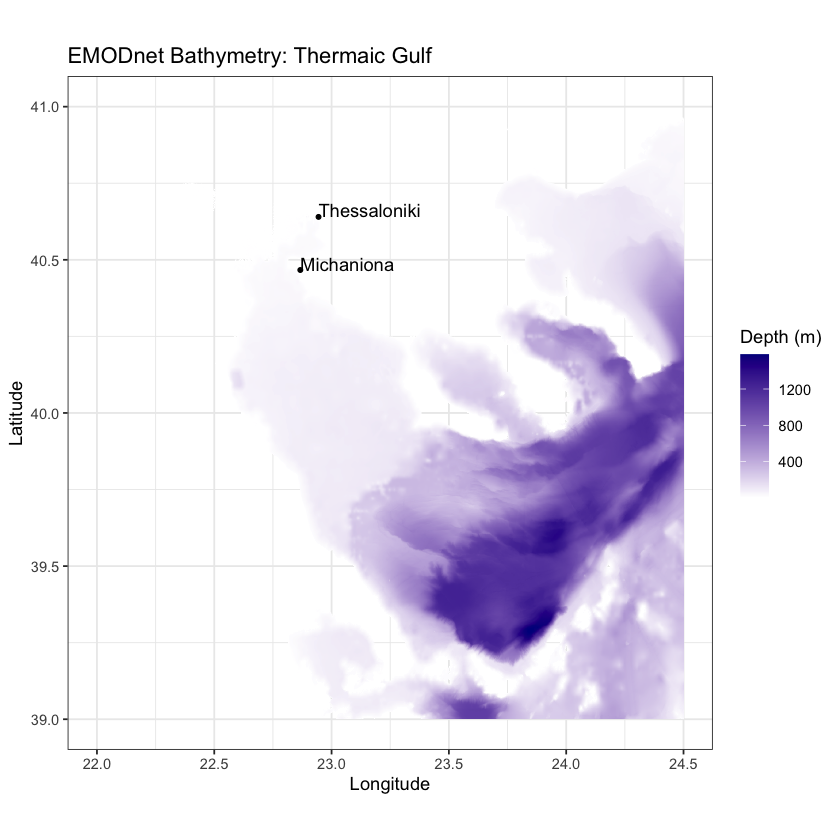

In [10]:
map <- ggplot(aes(x = x, y = y, z = emodnet.mean_img), data = bathy) +
  geom_tile(data = bathy, aes(fill = emodnet.mean_img)) +
  geom_point(data = city_coords, aes(x, y), size = 1, inherit.aes = FALSE) +
  geom_text(data = city_coords, aes(x, y, label = city), inherit.aes = FALSE,
            hjust = 0, vjust = 0) +
  scale_fill_gradient(low = "white", high = "darkblue", name = "Depth (m)") +
  coord_quickmap(xlim = range(xmin, xmax), ylim = range(ymin, ymax)) +
  ggtitle("EMODnet Bathymetry: Thermaic Gulf") +
  xlab("Longitude") +
  ylab("Latitude") +
  theme_bw()
map